# Welcome to NNLM Exercise ANN2

This exercise is split into three parts:
- In part 1, you will learn the fundamentals of RNNs
- In part 2, you will implement a basic RNN yourselves using numpy
- In part 3, you will implement an LSTM using pytorch

In this exercise you'll explore recurrent neural networks (RNNs), and some basic natural language processing (NLP). More specifically, your task will be to design an RNN from scratch using only numpy, similar to task 3 in ANN1. The goal of this network is to predict the correct next character given a sequence of characters. This is a simplified version of [causal language modelling](https://huggingface.co/docs/transformers/tasks/language_modeling), which is the main objective that is used to train large language models such as the [GPT series](http://jalammar.github.io/illustrated-gpt2/).

## Reading material
Before doing this exercise, please study the ANN2 module in Canvas and read Chapter 10 in the Deep Learning book, especially 10.2.2. If you want to learn more details about RNNs, we recommend [Andrej Karpathy's blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [this lecture](https://www.youtube.com/watch?v=0LixFSa7yts) and [this lecture](https://www.youtube.com/watch?v=6niqTuYFZLQ).

# Part 1 - RNN theory
## What is an RNN?
An RNN is a neural network just like the network you designed in ANN1, but with two important distinctions:
1) It iteratively produces outputs based on both inputs and previous (recurrent) outputs using shared parameters across time steps
2) It employs a "hidden state" that is iteratively computed and updated in each forward pass (the hidden state is not a trainable parameter)

### Sequence to sequence data
RNNs are used mainly for sequential data, i.e. data arranged in sequences where order matters. Typically, this is either time series data, such as weather forecasts or stock markets, or in NLP due to the sequential nature of language. The sequence-to-sequence (seq2seq) image below showcases a comprehensive example of ways sequential data can flow through an RNN.

![Seq2seq](http://karpathy.github.io/assets/rnn/diags.jpeg)

The leftmost rectangle is a normal feedforward network without RNNs, e.g. your digit predictor from ANN1. <br>
The "one to many" rectangle takes one input (non-sequential) and produces a sequence of output, e.g. image captioning which takes one image and produces a sequence of text in response. <br>
"many to one" is the opposite of image captioning, and can be for instance image generation, where a sequence of text is processed to produce one image. A simpler example is language classification tasks such as sentiment analysis. <br>
Finally, there are two examples of "many to many". The first example reads the entire input before producing an output, commonly seen in machine translation, where the model reads the whole text in one language to produce a hidden state that represents the latent meaning of the text, then decodes the hidden state to the translated language. The other example of many to many is synced, where each input requires one output in response, such as video frame classification.

**Exercise**: Briefly describe two major challenges and drawbacks with running a standard feed forward ANN (like the one from ANN1) on sequential data

Write your answer here:


### 1
One of the main problems for a standard feed forward ANN is the fixed Input and Output Sizes. Standard ANNs require a fixed input size, making them unsuitable for handling variable-length sequences. This rigidity limits their ability to process sequential data such as speech, text, or time-series signals, where input lengths may vary.
### 2
A standard feedforward ANNs process inputs independently and do not maintain any memory of previous inputs. This makes them ineffective for sequential data, where past information is often crucial for making accurate predictions

## RNN structure

![rnn-unroll image](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The above image explains the basics of an RNN quite well. Looking at the time-unfolded representation to the right, you'll see how the time-sequential data $x$ is transformed to the outputs $o$. The trainable parameters, the weight matrices in the network that you're building, consist of $U$, $V$, and $W$, where 


- $U$ defines the connections between the input sample $x_t$ and the current hidden state $h_t$
- $V$ defines the connections between the previous hidden state $h_{t-1}$ and $h_t$, and 
- $W$ defines the connections between the hidden state $h_t$ and the output $o_t$.


Note that, as per the seq2seq image above, all parameters are not always used in every time step.

This network can thus be represented mathematically as follows:
\begin{equation*}
h_t = f(U\,{x_t} + V\,{h_{t-1}})
\tag{1}
\end{equation*}

\begin{equation*}
o_t = \mathrm{softmax}(W\,{h_t})
\tag{2}
\end{equation*}


### A forward pass through an RNN
- Let's start at $t = 0$ and take two steps through this netowrk. <br>
- Initialise the hidden state h_init with zeros or randomly, $dims: [hidden\_size, 1]$. <br>
- Also initialise the parameters $U$, $V$, and $W$, again with zeros or randomly, since our network is not trained yet.
  - $U$ transforms the input to a hidden state contribution $input\_dim \rightarrow hidden\_size$.
  - $V$ updates the hidden state $hidden\_size \rightarrow hidden\_size$.
  - $W$ transforms the hidden state to the output $hidden\_size \rightarrow output\_dim$. <br>
- First, compute the hidden state $h_0$ as a function of $x_0*U$ and $h_{init} * V$. <br>
- Then, compute $o_0$ as a function of $h_0$ and $W$. <br>
- Then, for the next time step, compute $h_1$ as a function of $x_1*U$ and $h_0*V$. <br>
- Finally, compute $o_1$ based on $h_1*W$.<br>
- Note that the parameters $U$, $V$ and $W$ remain the same for each iteration. This is because the passing of the sequential data through the same network, as seen to the left of the image, which can be conceptualised as a network with shared weights, as in the right image. <br>
- Important: the hidden state $h$ is not learned, but produced during the recurrence. The weights to update the hidden state are learned however.

## How to train RNNs?

Well, you have to backpropagate through time, which thankfully is not as complicated as it sounds. <br>
The final loss between output $o_N$ and label $y_N$ will be a function not only of $x_N$, but of $h_N$. But $h_N$ is a function of $x_{N-1}$ and $h_{N-1}$, which is a function of ... <br>
You get the point, the longer the sequence in our network, the longer you have to roll back. <br>

### How to backpropagate through time?

It's not actually that much different compared to ANN1 if you do it step by step. Starting with the last output, $o_N$ in this case, compute the loss. Then backpropagate from loss to $o_N$, i.e. the derivate of the loss function. Then it is simple to calculate the contribution of $W$ to this loss, i.e. $dL/dW$. This is the contribution of $o_N$ to $W_{grad}$. Save this, but don't update yet! <br>
Next, backpropagate into $h_N$, similar to backpropagating into the activation function of $w_1$ in ANN1. Compute $dL/dh_N$, then also backprop through the activation function, as in ANN1. <br>
Think of these two steps as going backwards from the last output through $W$ to the last hidden state in the image above. 

Now, you're inside the hidden state, and you have to backprop in two directions. First, compute $dL/dU$, i.e. follow the $U$ arrow back to the input. <br>
Then, compute $dL/dV$, i.e. the contribution of the V parameter to the loss, following the arrow back towards the previous hidden state. Howver, you're not quite done yet, as you also want to compute the contribution of the previous hidden state to the loss, i.e. $dL/dh_{prev}$. Save this for next iteration. <br>
Take one time step back, and repeat the process, until you're at $t_0$. <br>

### But how does this process take time into account?

Note the last derivate you computed, $dL/dh_{prev}$. By solving the partial derivatives you'll find that when computing $dL/dh_{N}$, you relied on the "fake" hidden state not yet computed, $dL/dh_{prev}$, which you should initialise to zeros for the first (i.e. last) time step in the backprop. When you compute $dL/dh_{N-1}$ coming from $o_{N-1}$ and $W$, you must include $dL/dh_{prev}$, which this time won't be zero, and corresponds to the backwards movement through time.

# Part 2 - Implementing an RNN


##  Import packages
First, import some packages. We've put all support functions in another file to make the main notebook more readable. If you're interested in how data is loaded and processed, and some very basic NLP, feel free to have a look in the ANN2_support_functions.py file.

In [1]:
import numpy as np

import ANN2_support_functions
from importlib import reload
reload(ANN2_support_functions)
from ANN2_support_functions import set_up_datasets, init_orthogonal, one_hot_encode, one_hot_encode_sequence, sequences_to_dicts, set_up_sequences, clip_gradient_norm

## Set up data
Let's load the data from the support functions. You'll be using two datasets for this task. First, a "toy" dataset with simple generated sequences. The function returns four variables: <br>
sequence, which is a list of sequences of characters. The sequences have varying length. <br>
char_to_idx, a dict that converts a character to an index. <br>
idx_to_char, a dict that converts an index to a character. <br>
num_sequences, the number of the sequences

In [2]:
sequences, char_to_idx, idx_to_char, num_sequences, vocab_size = set_up_sequences('toy')
print('A sentence from the generated dataset:')
print(sequences[0])

print(f'There are {num_sequences} sentences and {len(char_to_idx)} unique tokens in our dataset (including UNK).\n')
print('The index of \'b\' is', char_to_idx['b'])
print(f'The char corresponding to index 1 is \'{idx_to_char[1]}\'')

training_set, validation_set, test_set = set_up_datasets(sequences)

A sentence from the generated dataset:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
There are 100 sentences and 4 unique tokens in our dataset (including UNK).

The index of 'b' is 1
The char corresponding to index 1 is 'b'
We have 80 samples in the training set.
We have 10 samples in the validation set.
We have 10 samples in the test set.


## Initialising the network
Recall the RNN structure from part 1 and use this knowledge to finish the code for network initialisation.

**Exercise**: Finish the init_network function below to set up the trainable parameters



$U  = (vocab\_size \rightarrow hidden\_size) \rightarrow$ This will firstly put to zero

$V  = (hidden\_size \rightarrow hidden\_size) \rightarrow$ This will firstly put to zero

$W  = (hidden\_size \rightarrow vocab\_size (output_size)) \rightarrow$ This will firstly put to zero




In [ ]:
def init_network(hidden_size, vocab_size):
    """
    Initialises the RNN parameters
    
    Args:
    `hidden_size`: the dimensions of the hidden state
    `vocab_size`: the dimensions of our vocabulary
    """

    # Weight matrix (input to hidden state)
    U = np.zeros((hidden_size, vocab_size))

    # Weight matrix (recurrent computation)
    V = np.zeros((hidden_size, hidden_size))

    # Weight matrix (hidden state to output)
    W = np.zeros((vocab_size, hidden_size))

    # Bias (hidden state)
    b_hidden = np.zeros((hidden_size, 1))

    # Bias (output)
    b_out = np.zeros((vocab_size, 1))

    
    
    # Initialize weights
    # You don't have to change anything here
    # Think of it as a better way of doing np.random.rand()
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)

    
    parameters = U, V, W, b_hidden, b_out

    return parameters

In [4]:
# Checking the init runs

hidden_size = 50 # Number of dimensions in the hidden state
vocab_size  = vocab_size # Size of the vocabulary used

parameters = init_network(hidden_size=hidden_size, vocab_size=vocab_size)


## The forward pass
Here you will implement the forward pass. You'll be using tanh as the activation function for the hidden state update (eq. 1), and softmax as the activation function for the output (eq. 2).

In [5]:
def tanh(x):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     x: the array where the function is applied
    """
    # Avoid division with zeros
    x = x + 1e-12
    # The tanh function
    a_x = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    return a_x
    
def softmax(x):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
    """
    # Avoid division with zeros
    x = x + 1e-12
    # The softmax function
    a_x = np.exp(x) / np.sum(np.exp(x))
    return a_x

**Exercise:** Finish the code for the forward pass

\begin{equation*}
h_t = f(U\,{x_t} + V\,{h_{t-1}})
\tag{1}
\end{equation*}

\begin{equation*}
o_t = \mathrm{softmax}(W\,{h_t})
\tag{2}
\end{equation*}


In [6]:
def forward_pass(inputs, hidden_state, parameters):
    """
    Computes the forward pass of a vanilla RNN.
    
    Args:
    `inputs`: sequence of inputs to be processed
    `hidden_state`: an already initialized hidden state
    `parameters`: the parameters of the RNN
    """
    # First unpack parameters
    U, V, W, b_hidden, b_out = parameters
    
    # Create a list to store outputs and hidden states
    outputs, hidden_states = [], []
    
    # For each element in input sequence
    for t in range(len(inputs)):

        # Compute new hidden state
        # Hint: look at eq. 1
        # TODO:
        hidden_state = tanh(np.dot(U, inputs[t]) + np.dot(V, hidden_state) + b_hidden)

        # Compute output
        out = softmax(np.dot(W, hidden_state) + b_out)
        
        # Save results and continue
        outputs.append(out)
        hidden_states.append(hidden_state.copy())
    
    return outputs, hidden_states

In [7]:
# Checking the forward pass

# Get first sequence in training set
test_input_sequence, test_target_sequence = training_set[0]

# One-hot encode input and target sequence
test_input = one_hot_encode_sequence(test_input_sequence, vocab_size, char_to_idx)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size, char_to_idx)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Now let's try out our new function
outputs, hidden_states = forward_pass(test_input, hidden_state, parameters)

print('Input sequence:')
print(test_input_sequence)

print('\nTarget sequence:')
print(test_target_sequence)

print('\nPredicted sequence:')
print([idx_to_char[np.argmax(output)] for output in outputs])

Input sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['UNK', 'UNK', 'UNK', 'b', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'EOS', 'EOS', 'b']


## The backward pass
**Exercise:** Finish the code for the backward pass

## **Backpropagation Through Time (BPTT) - Mathematical Steps**

### Cross-Entropy Loss Computation
$\text{loss} + =  -np.mean(np.log(outputs[t]+ 1e^{-12})*targets[t]$
- This compute the cross-entropy loss between the predicted output[t] and the true label targets[t]
- A $1e^{-12}$ is added to avoid log(0)

### Gradient of softmax and cross-entropy
$d_o = outputs[t].copy()$

$d_o[np.argmax(targets[t])] -= 1$
- This compute the gradient of the softmax + cross-entropy loss
- Instead of computing separate gradients for softmax and cross-entropy , we use the fact that their derivative simplifies to :

$
\frac{\partial L}{\partial z_i} = \text{softmax}(z_i) - y_i
$

- $ z_i $ is the pre-activation output of the last layer,
- $ y_i $ is the true label,

### Backpropagation into Weight Matrices
Each weight matrix is updated based on the error signal.

$d_W += np.dot(d_o, hidden_states[t].T)$
- W connects the hidden state to the output.
- The gradient update follows :  $\frac{\partial L}{\partial W} = d_o \cdot h^T$

- $d_o$ is the gradient from the softmax output
-  $h^T$  is the transposed hidden state.

- Updating Bias for output Layer

d_b_out += d_o

### Backpropagation into Hidden Layer
d_h = np.dot(W.T, d_o) + d_h_prev

- $d_h$ accumulates gradients flowing back from the output and previous hidden states.

- $d_h = W^T d_o + d_h^{(t+1)}$

$d_o$ comes from the softmax layer

$d_{h}^{t+1}$ is is the previous hidden state gradient

#### Activation Function Derivative
d_o = d_h * (1 - hidden_states[t] ** 2)

- This applies the derivative of the tanh activation function:

$\frac{d}{dx} \tanh(x) = 1 - \tanh^2(x)$

### Backpropagation into Input and Recurrent Weights
#### Bias for Hidden Layer
d_b_hidden += d_o
- Accumulates gradients for the hidden bias term.
#### Gradient for Input Weight Matrix 𝑈
- d_U += np.dot(d_o, inputs[t].T)
- $\frac{\partial L}{\partial U} = d_o \cdot x^T$
- - $x^T$ is the input at time step t
#### Gradient for Recurrent Weight Matrix 𝑉
- d_V += np.dot(d_o, hidden_states[t].T)
- $\frac{\partial L}{\partial V} = d_o \cdot h_{t-1}^T$
- ensuring gradients flow into the previous hidden state.

### Passing Gradient to Previous Hidden State
- d_h_prev = np.dot(V.T, d_o)
- This propagates gradients back to the previous hidden state $h_{t-1}$, continuing the Backpropagation Through Time (BPTT).

## Summary
1. Compute loss using cross-entropy.
2. Compute gradient of softmax + cross-entropy efficiently.
3. Backpropagate into:
- Output weights 𝑊
- Hidden-to-output bias
- Hidden state (tanh derivative)
- Input weights 𝑈
- Recurrent weights 𝑉
- Previous hidden state gradient for BPTT

This process is repeated for all time steps in reverse order, enabling the network to learn from sequences.








In [8]:
def backward_pass(inputs, outputs, hidden_states, targets, parameters):
    """
    Computes the backward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `outputs`: sequence of outputs from the forward pass
     `hidden_states`: sequence of hidden_states from the forward pass
     `targets`: sequence of targets
     `params`: the parameters of the RNN
    """
    # First unpack parameters
    U, V, W, b_hidden, b_out = parameters
    
    # Initialize gradients as zero
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
    # Keep track of hidden state derivative and loss
    d_h_prev = np.zeros_like(hidden_states[0])
    loss = 0
    
    # For each element in output sequence
    # iterate backwards over t -> t = N, N-1, ... 1, 0
    for t in reversed(range(len(outputs))):

        # Compute cross-entropy loss
        loss += -np.mean(np.log(outputs[t]+1e-12) * targets[t])
        
        # Backpropagate into output (derivative of cross-entropy and softmax)
        # dL/do cancels out all annoying parts of dL/dz * dz/do into a simple function
        # please see https://davidbieber.com/snippets/2020-12-12-derivative-of-softmax-and-the-softmax-cross-entropy-loss/
        # for more details
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] -= 1
        
        # Backpropagate into W
        # TODO:
        d_W += np.dot(d_o, hidden_states[t].T)
        
        # Backpropagate into bias
        d_b_out += d_o
        
        # Backpropagate into h
        # TODO:
        d_h = np.dot(W.T, d_o) + d_h_prev

        
        # Backpropagate through the activation function
        d_o = d_h * (1 - hidden_states[t] ** 2)

        # Backpropagate into bias
        d_b_hidden += d_o
        
        # Backpropagate into U
        d_U += np.dot(d_o, inputs[t].T)
        # Backpropagate into V
        # TODO:
        d_V += np.dot(d_o, hidden_states[t].T)
        
        # Backpropagate into previous hidden state
        d_h_prev = np.dot(V.T, d_o)
    
    # Pack gradients
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
    # Clip gradients to prevent explosions
    grads = clip_gradient_norm(grads)
    
    return loss, grads

In [9]:
# Checking the backwards pass

# Perform a backward pass
loss, gradients = backward_pass(test_input, outputs, hidden_states, test_target, parameters)

print('We get a loss of:')
print(loss)

We get a loss of:
4.553408581307238


## The optimisation algorithm
**Exercise:** Finish the code for gradient descent

In [10]:
def gradient_descent(parameters, gradients, lr=1e-3):
    # Take a step
    updated_params = []
    for parameter, gradient in zip(parameters, gradients):
        #TODO: 
        parameter -= lr * gradient
        updated_params.append(parameter)
    return updated_params

In [11]:
# Check that our gradient descent works
# Ignore all the arcane unrolling of lists. All this function does is to check that your update function actually changes the parameters

# Copy old parameters so we can check that they've updated
prev_parameters = [parameter.copy() for parameter in parameters]

# Use computed gradients to update parameters
parameters = gradient_descent(parameters, gradients, lr=3e-4)

# Check that parameters have updated
parameters_delta = [parameter - prev_parameter for parameter, prev_parameter in zip(parameters, prev_parameters)]

assert all([parameter.any() for parameter in parameters_delta]), "parameters have not updated"
print("parameters seem to update during backprop")


parameters seem to update during backprop


## Training the network
**Exercise:** Implement all individual steps together to loop over the dataset. Train until you have a loss under 2 or an accuracy over 50%.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Hyper-parameters
num_epochs = 5000
hidden_size = 50

# Initialize a new network
parameters = init_network(hidden_size=hidden_size, vocab_size=vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# Keep track of best validation loss
min_loss = 10000

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
     # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size, char_to_idx)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size, char_to_idx)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, parameters)

        # Compute loss

        # Backward pass
        loss, gradients = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, parameters)

        # If lowest val loss, save parameters of model
        if loss<min_loss:
            best_parameters = parameters
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size, char_to_idx)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size, char_to_idx)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, parameters)


        # Backward pass
        loss, gradients = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, parameters)# Forward pass
        
        
        if np.isnan(loss):
            raise ValueError('Gradients have vanished!')
        
        # Update parameters
        # TODO: 
        updated_parameters = gradient_descent(parameters, gradients, lr=3e-4)       
        
        # Update loss
        epoch_training_loss += loss
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 100 epochs
    if i % 50 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


# Get first sentence in train set
inputs, targets = training_set[0]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size, char_to_idx)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size, char_to_idx)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
# TODO:
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, parameters)
output_sentence = [idx_to_char[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_char[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

Epoch 0, training loss: 3.7025949433895193, validation loss: 3.7253638510366778
Epoch 50, training loss: 3.0132395010129724, validation loss: 3.025634718918331
Epoch 100, training loss: 2.5021596404072524, validation loss: 2.513976900893296
Epoch 150, training loss: 2.1644029034569465, validation loss: 2.1791968068230365
Epoch 200, training loss: 1.944456911907844, validation loss: 1.9636584300755575


KeyboardInterrupt: 

In [ ]:
# Testing your network

# Get first sequence in testing set
test_input_sequence, test_target_sequence = test_set[0]

# One-hot encode input and target sequence
test_input = one_hot_encode_sequence(test_input_sequence, vocab_size, char_to_idx)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size, char_to_idx)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
# TODO:
outputs, hidden_states = forward_pass(test_input, hidden_state, parameters)

print('Input sequence:')
print(test_input_sequence)

print('\nTarget sequence:')
print(test_target_sequence)

preds = [idx_to_char[np.argmax(output)] for output in outputs]
print('\nPredicted sequence:')
print(preds)

accuracy = 0
for target, pred in zip(test_target_sequence, preds):
    accuracy += target == pred
accuracy /= len(test_target_sequence)/100

print(f"Test accuracy is {np.round(accuracy)}%.") 

Input sequence:
["'", 't', 'h', 'e', 'y', 'h', 'a', 'v', 'e', 'p', 'r', 'e', 's', 's', "'", 'd', 'a', 'p', 'o', 'w', 'e', 'r', 'b', 'u', 't', 'i', 't', 'i', 's', 'n', 'o', 't', 'k', 'n', 'o', 'w', 'n', 'w', 'h', 'e', 't', 'h', 'e', 'r', 'f', 'o', 'r', 'e', 'a', 's', 't', 'o', 'r', 'w', 'e', 's', 't', 't', 'h', 'e', 'd', 'e', 'a', 'r', 't', 'h', 'i', 's', 'g', 'r', 'e', 'a', 't', ';', 't', 'h', 'e', 'p', 'e', 'o', 'p', 'l', 'e', 'm', 'u', 't', 'i', 'n', 'o', 'u', 's', ';', 'a', 'n', 'd', 'i', 't', 'i', 's', 'r', 'u', 'm', 'o', 'u', 'r', "'", 'd', 'c', 'o', 'm', 'i', 'n', 'i', 'u', 's', 'm', 'a', 'r', 'c', 'i', 'u', 's', 'y', 'o', 'u', 'r', 'o', 'l', 'd', 'e', 'n', 'e', 'm', 'y', 'w', 'h', 'o', 'i', 's', 'o', 'f', 'r', 'o', 'm', 'e', 'w', 'o', 'r', 's', 'e', 'h', 'a', 't', 'e', 'd', 't', 'h', 'a', 'n', 'o', 'f', 'y', 'o', 'u', 'a', 'n', 'd', 't', 'i', 't', 'u', 's', 'l', 'a', 'r', 't', 'i', 'u', 's', 'a', 'm', 'o', 's', 't', 'v', 'a', 'l', 'i', 'a', 'n', 't', 'r', 'o', 'm', 'a', 'n', 't'

## Trying a more complex task
The you dataset is an extremely simple set of characters to predict. Now, let's try using a more complicated dataset. The code below imports data from a collection of Shakespeare's plays and turns it into sequences of characters. Try running your network on this data and see if it works.

**Exercise:** Paste and run your training and testing on the Shakespeare dataset. You don't have to achieve any specific loss or accuracy. Does it work? Please speculate on why/why not.

Your answer here:


Increased Complexity: Shakespearean text includes a rich vocabulary, varying sentence structures, and old-fashioned words. The model has to learn longer-term dependencies.

Longer Sequences: The dataset consists of much longer passages of text, making it harder for an RNN to retain information over long spans.

Vanishing Gradient Problem: Standard RNNs often have difficulty remembering long-term dependencies due to vanishing gradients.

Data Sparsity: Because the text includes many rare words and phrases, the model might not see certain sequences enough times to learn them effectively.

Training Time: A complex dataset requires significantly more training epochs to produce coherent output.

In [13]:
sequences, char_to_idx, idx_to_char, num_sequences, vocab_size = set_up_sequences()

#num_sequences = len(sequences)
#vocab_size = len(np.unique(sequences))
print('A sentence from the Shakespeare dataset:')

# Whole dataset is too big to effectively train on, so let's start by grabbing the first 100 sequences
sequences = sequences[0:200]
training_set, validation_set, test_set = set_up_datasets(sequences)

A sentence from the Shakespeare dataset:
We have 160 samples in the training set.
We have 20 samples in the validation set.
We have 20 samples in the test set.


**Exercise:** Your code for training and testing here

Epoch 0, training loss: 11.652439338814515, validation loss: 11.220912684485834
Epoch 50, training loss: 11.106904982579135, validation loss: 10.695129548994178
Epoch 100, training loss: 10.593043547591904, validation loss: 10.169113892920567
Epoch 150, training loss: 10.26503506033262, validation loss: 9.83249340200571
Epoch 200, training loss: 10.054034146775347, validation loss: 9.611556045739448
Epoch 250, training loss: 9.927393216042317, validation loss: 9.473609744087582
Epoch 300, training loss: 9.847844098089892, validation loss: 9.38455095051439
Epoch 350, training loss: 9.793287194161913, validation loss: 9.323374106531631
Epoch 400, training loss: 9.753222271013342, validation loss: 9.278955508120255
Epoch 450, training loss: 9.722436587825639, validation loss: 9.245244597454535
Epoch 500, training loss: 9.6980149877722, validation loss: 9.218746215834491
Epoch 550, training loss: 9.678132773397277, validation loss: 9.197300326964081
Epoch 600, training loss: 9.661561149928

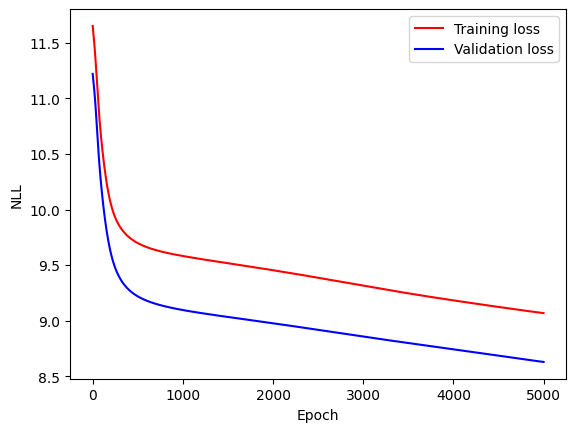

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Hyper-parameters
num_epochs = 5000
hidden_size = 50

# Initialize a new network
parameters = init_network(hidden_size=hidden_size, vocab_size=vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# Keep track of best validation loss
min_loss = 10000

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
     # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size, char_to_idx)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size, char_to_idx)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, parameters)

        # Compute loss

        # Backward pass
        loss, gradients = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, parameters)

        # If lowest val loss, save parameters of model
        if loss<min_loss:
            best_parameters = parameters
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size, char_to_idx)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size, char_to_idx)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, parameters)


        # Backward pass
        loss, gradients = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, parameters)# Forward pass
        
        
        if np.isnan(loss):
            raise ValueError('Gradients have vanished!')
        
        # Update parameters
        # TODO: 
        gradient_descent(parameters, gradients, lr=3e-4)       
        
        # Update loss
        epoch_training_loss += loss
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 100 epochs
    if i % 50 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


# Get first sentence in train set
inputs, targets = training_set[0]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size, char_to_idx)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size, char_to_idx)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
# TODO:
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, parameters)
output_sentence = [idx_to_char[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_char[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [14]:
# Testing your network

# Get first sequence in testing set
test_input_sequence, test_target_sequence = test_set[0]

# One-hot encode input and target sequence
test_input = one_hot_encode_sequence(test_input_sequence, vocab_size, char_to_idx)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size, char_to_idx)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
# TODO:
outputs, hidden_states = forward_pass(test_input, hidden_state, parameters)

print('Input sequence:')
print(test_input_sequence)

print('\nTarget sequence:')
print(test_target_sequence)

preds = [idx_to_char[np.argmax(output)] for output in outputs]
print('\nPredicted sequence:')
print(preds)

accuracy = 0
for target, pred in zip(test_target_sequence, preds):
    accuracy += target == pred
accuracy /= len(test_target_sequence)/100

print(f"Test accuracy is {np.round(accuracy)}%.") 

ValueError: shapes (50,4) and (36,1) not aligned: 4 (dim 1) != 36 (dim 0)

# Part 3 - LSTMs

One of the most famous challenges for RNNs is [the vanishing gradient problem](http://neuralnetworksanddeeplearning.com/chap5.html#the_vanishing_gradient_problem), where the gradient, i.e. the signal to update our weights, goes to zero due to repetetive multiplications of values <1 in the backprop (or goes to oo due to repetetive multiplications of values >1 in what's called exploding gradient). This can happen to all networks, but RNNs are far more vulnurable to it due to the long sequences of backprops through time. In this section of the lab you'll see how this issue can be addressed, and 

Please read through [Christopher Olah's walk through](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) to understand this issue and its solutions in more detail.

![Vanilla RNN](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)
![Terminology](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png)

The image above represents a normal "vanilla" RNN, with the yellow "tanh" rectangle symbolising our current network. $h_t$ represents the output in this image, so as you can see there's the x->hidden state connection, hidden state update connection, and hidden state->output connection. 

To amend the issue of vanishing gradients, gated hidden units were introduced, which act like a highway between states to facilitate modelling long-range dependencies. Two famous solutions exist, one called "long short-term memory" (LSTM) and the other "gated recurrent unit" (GRU). Today, we're going to look a bit closer at the LSTM (don't worry though, you're using pytorch to implement it this time).

The image below, fully explained in the walk through, shows the schematic of an LSTM cell. The fundamentals from our vanilla RNN are still there, namely the tanh of our input and previous hidden state, but we now have a "cell state", which acts as the aforementioned highway, and three "gates" which update this cell state.

The three gates are the input gate $i$, the forget gate $f$, and the output gate $o$. They are defined as 
\begin{equation*}
\begin{aligned}
i = \sigma ( W^i [h_{t-1}, x_t])\\
f = \sigma ( W^f [h_{t-1},x_t])\\
o = \sigma ( W^o [h_{t-1},x_t])
\end{aligned}
\tag{2}
\end{equation*}


where $W^i$, $W^f$, and $W^o$ are the weight matrices applied to $h_{t-1},x_t$.

![LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

**Exercise:** Read the walk through above and explain the function of the three gates

Write your answer here:
### Input gate:

OBS! To my understanding reading about this, you can also apply a bias in each Gate in order to provide an additional degree of freedom that helps fine-tune how much information is retained or forgotten.

1. Determines how much of the new input $x_t$ and previous hidden state ($h_{t-1}$) should be used to update/stored in the cell state.
2. Uses a sigmoid activation function ($\sigma$) to produce values between 0 and 1, where:
    - 0 means "ignore new inforamtion"
    - 1 means "fully accept new information"
3. $i = \sigma ( W^i [h_{t-1}, x_t]+b^i)$
    - $W^i$ is the weight matrix for the input gate
    - $[h_{t-1}, x_t]$ is joining of the matrices hidden state ($h_{t-1}$) and the current input $x_t$
    - $b^i$ is the bias term
    - $\sigma$ or sigmoid function is used to get the value between 0 and 1
### Forget gate:
1. Controls what portion of the previous cell state ($C_{t-1}$) should retained or forgotten
2. Also uses a sigmoid function, where:
    - 0 means "completely forget"
    - 1 means " full retain"
3. $f = \sigma ( W^f [h_{t-1}, x_t]+b^f)$
    - $W^f$ is the weight matrix for the forget gate
    - $[h_{t-1}, x_t]$ is joining of the matrices hidden state ($h_{t-1}$) and the current input $x_t$
    - $b^i$ is the bias term
    - $\sigma$ or sigmoid function is used to get the value between 0 and 1
4. This is what allows LSTMs to selectively forget outdated information.


### Output gate:
1. Determines how much of the current cell state ($C_t$) should be used to compute the next hidden state $(h_t)$
2. Uses a sigmoid function to regulate the amount of memory output to the next step
3. $o = \sigma ( W^o [h_{t-1}, x_t]+b^o)$
    - $W^o$ is the weight matrix for the output gate
    - $[h_{t-1}, x_t]$ is joining of the matrices hidden state ($h_{t-1}$) and the current input $x_t$
    - $b^i$ is the bias term
    - $\sigma$ or sigmoid function is used to get the value between 0 and 1
4. This controls the amount of information that is exposed to the rest of the network.


## Using an LSTM with Pytorch
Now for your final task. Having learned how LSTMs work in theory, it's now time to put this knowledge into practice.

Using the [LSTM pytorch documentations](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html), build and train an LSTM network and compare it to your self-made RNN. You won't need to import any more packages than those already imported, but you're free to use any approach as long as you can defend it during the presentation.

**Exercise:** Build the LSTM network


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size = 25,output_size = 1):
        super(LSTM, self).__init__()
        num_layers = 1
        # Recurrent layer
        # TODO:
        self.lstm = nn.LSTM(input_size=input_size,
                 hidden_size=hidden_size,
                 num_layers=num_layers,
                 bidirectional=False)
        
        # Output layer
        self.l_out = nn.Linear(in_features=hidden_size,
                            out_features=output_size,
                            bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        # TODO:
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)
        
        # Output layer
        # TODO:
        x = self.l_out(x)
        return x

## Setting up the network hyperparameters

In [21]:
# Initialise our network
model = LSTM(36,50,36)
print(model)
min_LSTM_loss = 10000

# Store training and validation loss
training_loss, validation_loss = [], []

# Define a loss function and optimizer for this problem
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
# A way to get learning rate decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

LSTM(
  (lstm): LSTM(36, 50)
  (l_out): Linear(in_features=50, out_features=36, bias=False)
)


## Train the network
**Exercise:** Finish the training code until you have at least 25% accuracy. If you're willing to train for a long time, feel free to use more data and bigger models.

In [ ]:
# Hyper-parameters
num_epochs = 45

import matplotlib.pyplot as plt
%matplotlib inline

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    model.eval()
        
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size, char_to_idx)
        targets_idx = [char_to_idx[char] for char in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # TODO:
        outputs = model.forward(inputs_one_hot)
        
        # Compute loss
        # TODO:
        loss = criterion(outputs, targets_idx)

        if loss<min_LSTM_loss:
            torch.save(model, 'best_model.pt')
        
        # Update loss
        epoch_validation_loss += loss.detach().numpy()
    
    model.train()
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size, char_to_idx)
        targets_idx = [char_to_idx[char] for char in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # TODO:
        outputs = model(inputs_one_hot)
        
        # Compute loss
        # TODO: 
        loss = criterion(outputs, targets_idx)

        
        # Reset gradients
        # TODO:
        optimizer.zero_grad()

        # Compute gradients
        # TODO:
        loss.backward()

        # Update weights
        # TODO:
        optimizer.step()

        # Update learning rate (advanced technique, can be ignored)
        scheduler.step()
        
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

# Plot training and validation loss
epoch = np.arange(len(training_loss))

# Get first sentence in training set
inputs, targets = training_set[0]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size, char_to_idx)
targets_idx = [char_to_idx[char] for char in targets]

# Convert input to tensor
inputs_one_hot = torch.Tensor(inputs_one_hot)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convert target to tensor
targets_idx = torch.LongTensor(targets_idx)


# Forward pass
# TODO:
# Load the best model
best_model = torch.load('best_model.pt')

# Forward pass for the first training example
outputs = best_model.forward(inputs_one_hot).data.numpy()

print('\nInput sequence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

preds = [idx_to_char[np.argmax(output)] for output in outputs]
print('\nPredicted sequence:')
print(preds)

plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [ ]:
best_model = torch.load('best_model.pt')

# Get first sentence in test set
test_input_sequence, test_target_sequence = test_set[0]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(test_input_sequence, vocab_size, char_to_idx)
targets_idx = [char_to_idx[char] for char in test_target_sequence]

# Convert input to tensor
inputs_one_hot = torch.Tensor(inputs_one_hot)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convert target to tensor
targets_idx = torch.LongTensor(targets_idx)

# Forward pass
# TODO:
outputs = best_model.forward(inputs_one_hot).data.numpy()
print('\nInput sequence:')
print(test_input_sequence)

print('\nTarget sequence:')
print(test_target_sequence)

preds = [idx_to_char[np.argmax(output)] for output in outputs]
print('\nPredicted sequence:')
print(preds)

accuracy = 0
for target, pred in zip(test_target_sequence, preds):
    accuracy += target == pred
accuracy /= len(test_target_sequence)/100

print(f"Test accuracy is {np.round(accuracy)}%.") 

## Final comments (extracurricular)
Now you've seen how RNNs work and implemented a very simple causal language model. If you want to improve it, besides grabbing more data and building bigger models, you could also improve on character-based tokens to n_grams or subwords; make your word embeddings (hidden state) contextual, upgrade your model to a transformer or a state space model, and suddenly you've designed GPT, BERT, T5, LLaMA, or any other "modern" large language model. Though RNNs aren't the most popular due to the dominance of the transformer, models such as state space models, which exist inbetween RNNs and transformers, show that much innovation is still possible by merging these two frameworks.